In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import os
import cv2
from PIL import Image
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

In [ ]:
image_directory = "/content/drive/MyDrive/Breast Cancer Dataset With Masks/"

In [ ]:
def load_images(image_folder, label_value):
    images = [img for img in os.listdir(image_directory + image_folder)]
    for image_name in images:
        if image_name.split('.')[1] == 'png' and '_mask' not in image_name:
            image = cv2.imread(image_directory + image_folder + image_name)
            if image is not None:
                image = Image.fromarray(image, 'RGB')
                image = image.resize((SIZE, SIZE))
                image = np.array(image)
                dataset.append(image)
                label.append(label_value)

In [ ]:
SIZE = 224
dataset = []
label = []

In [ ]:
load_images('benign/', 0)
load_images('malignant/', 1)

In [ ]:
# Convert dataset and label to numpy arrays
dataset = np.array(dataset)
label = np.array(label)

In [ ]:
def custom_preprocessing(image):
    noisy_image = add_noise_to_image(image)
    blurred_image = apply_blur_to_image(noisy_image)
    enhanced_image = adjust_contrast_brightness(blurred_image)
    return enhanced_image

def add_noise_to_image(image):
    noisy_image = np.clip(image + np.random.normal(loc=0, scale=0.1, size=image.shape), 0, 1)
    return noisy_image

def apply_blur_to_image(image):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    return blurred_image

def adjust_contrast_brightness(image):
    img = (image * 255).astype(np.uint8)
    pil_img = Image.fromarray(img)
    enhancer = ImageEnhance.Contrast(pil_img)
    enhanced_img = enhancer.enhance(1.5)
    enhancer = ImageEnhance.Brightness(enhanced_img)
    enhanced_img = enhancer.enhance(1.2)
    enhanced_img = np.array(enhanced_img) / 255.0
    return enhanced_img

In [ ]:
# Split the dataset into train and test sets
num_samples, height, width, channels = dataset.shape
X_flat = dataset.reshape(num_samples, -1)
X_train, X_test, y_train, y_test = train_test_split(X_flat, label, test_size=0.25, random_state=42)
X_train = X_train.reshape(-1, 224, 224, 3)


In [ ]:
augmentation_class1 = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=custom_preprocessing
)
augmentation_class2 = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=custom_preprocessing

)

In [ ]:
# General Augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)
augmented_images = []
augmented_labels = []
augmentation_factor = 2

for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=len(X_train), shuffle=False):
    augmented_images.append(x_batch)
    augmented_labels.append(y_batch)
    if len(augmented_images) >= augmentation_factor:
        break

In [ ]:
# Concatenate the augmented data batches
X_train = np.concatenate(augmented_images)
y_train = np.concatenate(augmented_labels)

In [ ]:
print("Shape of augmented images:", X_train.shape)
print("Shape of augmented labels:", y_train.shape)

Shape of augmented images: (846, 224, 224, 3)
Shape of augmented labels: (846,)


In [ ]:
def apply_augmentation(X_train, y_train):
    if y_train == 1:
        return augmentation_class1.random_transform(X_train), y_train
    if y_train == 2:
        return augmentation_class2.random_transform(X_train), y_train
    else:
        return X_train, y_train
X_test= X_test.reshape(-1, 224, 224, 3)

In [ ]:
# Compute class weights
class_labels = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)
class_weights[1] *= 10.0
class_weight = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
# Define ResNet50 model
INPUT_SHAPE = (224, 224, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)
pretrained_model = keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='max',
    classes=2,
    weights='imagenet'
)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
print(pretrained_model.summary())


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
model = Sequential()
model.add(pretrained_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
for layer in pretrained_model.layers:
    layer.trainable = False

for layer in pretrained_model.layers[-12:]:
    layer.trainable = True

In [ ]:
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
y_train_binary = (y_train == 1).astype(int)
y_test_binary = (y_test == 1).astype(int)
y_train = y_train_binary
y_test = y_test_binary

In [ ]:
# Define checkpoint to save the best model
checkpoint_path = 'best_model.weights.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max',
                             save_weights_only=True)

In [ ]:
# Fit the model
history = model.fit(np.array(X_train),
                    y_train,
                    batch_size=32,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    shuffle=True,
                    class_weight=class_weight,
                    callbacks=[checkpoint])

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 2.9874 - accuracy: 0.5331
Epoch 1: val_accuracy improved from -inf to 0.79433, saving model to best_model.weights.h5
27/27 [==============================] - 22s 329ms/step - loss: 2.9874 - accuracy: 0.5331 - val_loss: 3.8491 - val_accuracy: 0.7943
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 1.0839 - accuracy: 0.5733
Epoch 2: val_accuracy improved from 0.79433 to 0.80851, saving model to best_model.weights.h5
27/27 [==============================] - 4s 152ms/step - loss: 1.0839 - accuracy: 0.5733 - val_loss: 1.0876 - val_accuracy: 0.8085
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 0.9438 - accuracy: 0.6348
Epoch 3: val_accuracy improved from 0.80851 to 0.85816, saving model to best_model.weights.h5
27/27 [==============================] - 4s 152ms/step - loss: 0.9438 - accuracy: 0.6348 - val_loss: 0.5884 - val_accuracy: 0.8582
Epoch 4/50
27/27 [===========================

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
# Extract features from the last layer of ResNet50 model
feature_extractor = keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

6/6 [==============================] - 1s 83ms/step


In [ ]:
# Standardize features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

In [ ]:
# Train SVM classifier
svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(train_features_scaled, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
# # Evaluate SVM classifier
svm_accuracy = svm_classifier.score(test_features_scaled, y_test)
print("SVM Accuracy:", svm_accuracy)

SVM Accuracy: 0.8466257668711656


In [ ]:
# Generate predictions using SVM classifier
svm_predictions = svm_classifier.predict(test_features_scaled)

In [ ]:
# # Classification report and confusion matrix for SVM
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_predictions))
print("\nSVM Confusion Matrix:")
print(confusion_matrix(y_test, svm_predictions))



SVM Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       118
           1       0.69      0.82      0.75        45

    accuracy                           0.85       163
   macro avg       0.81      0.84      0.82       163
weighted avg       0.86      0.85      0.85       163


SVM Confusion Matrix:
[[101  17]
 [  8  37]]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, svm_predictions)

precision = precision_score(y_test, svm_predictions, average='weighted')

recall = recall_score(y_test, svm_predictions, average='weighted')

f1 = f1_score(y_test, svm_predictions, average='weighted')

from sklearn.metrics import precision_score, recall_score

# Calculate precision and recall for each class
precision = precision_score(y_test, svm_predictions, average=None)
recall = recall_score(y_test, svm_predictions, average=None)
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(y_test, svm_predictions)

# Calculate specificity
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # Specificity for class (benign)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity)


Accuracy: 0.8466257668711656
Precision: [0.9266055  0.68518519]
Recall: [0.8559322  0.82222222]
F1 Score: 0.8505568645564862
Specificity: 0.8559322033898306


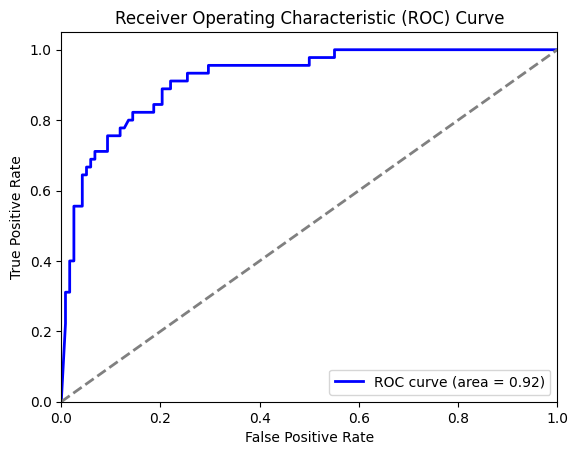

In [ ]:
# Compute ROC curve and ROC area for binary classification
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for binary classification
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


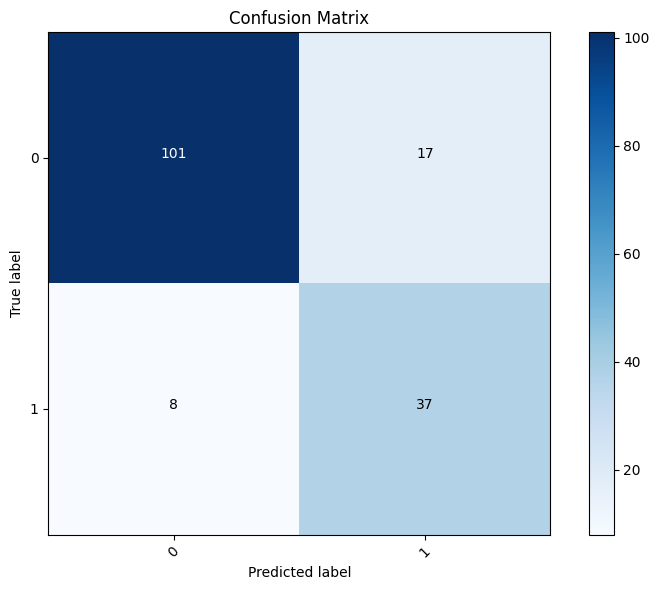

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, svm_predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Set tick marks and labels
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Add text annotations
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


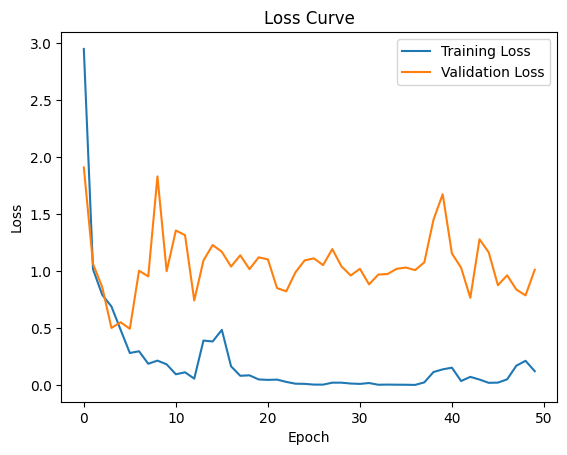

In [ ]:
# Loss curve
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

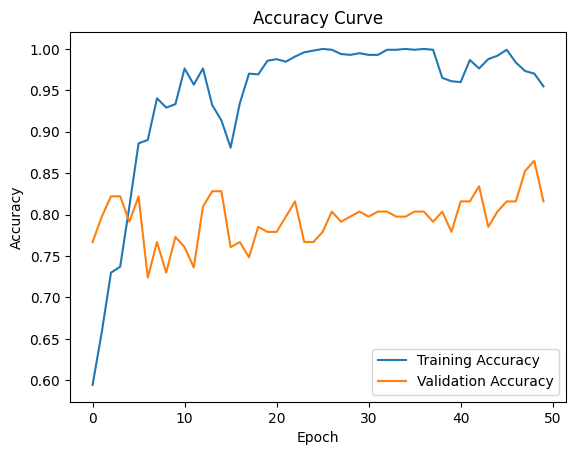

In [ ]:
# Accuracy curve
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 46ms/step


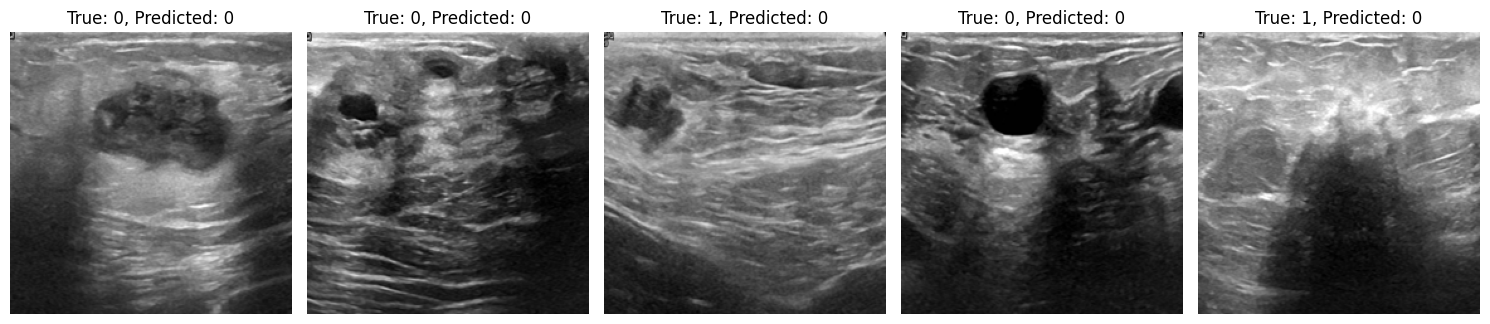

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get some random indices from the test set
num_samples_to_display = 5
random_indices = np.random.choice(X_test.shape[0], num_samples_to_display, replace=False)

images_to_display = X_test[random_indices]
true_labels = y_test[random_indices]
predicted_labels = model.predict(images_to_display)
predicted_labels = np.argmax(predicted_labels, axis=1)

true_labels_int = true_labels

plt.figure(figsize=(15, 5))
for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(images_to_display[i].reshape(SIZE, SIZE, 3))
    plt.title(f"True: {true_labels_int[i]}, Predicted: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
